In [60]:
import src.data.dataFunctions as dl
import src.utilis.utilis as ut
import src.utilis.plotting as pl 
import pandas as pd
import numpy as np
from IPython.display import display
import warnings
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Load and Prepare Data
First, we load all the necessary data files using our custom processing function. This function handles reading the CSVs, cleaning subreddit names, and filtering the datasets based on the list of approved subreddits.

In [62]:
COUNTRY_FILE = "data/country_matches_map_expanded.csv"  
EMBEDDINGS_FILE = "data/web-redditEmbeddings-subreddits.csv" 
TITLE_FILE = "data/soc-redditHyperlinks-title.tsv"
BODY_FILE = "data/soc-redditHyperlinks-body.tsv"        


df_countries=dl.load_country_subreddits(COUNTRY_FILE)
df_embeddings=dl.load_embeddings(EMBEDDINGS_FILE)
df_posts=dl.load_post_data(TITLE_FILE, BODY_FILE)
df_post_with_1_country, df_post_between_countries=dl.filter_posts_by_country(df_posts, df_countries)

print(f"\nLoaded {len(df_countries)} approved country-related subreddits.")
print(f"Loaded {len(df_embeddings)} embeddings.")
print(f"Loaded {len(df_post_with_1_country)} posts with at least one approved country-related subreddit.")
print(f"Loaded {len(df_post_between_countries)} posts between approved country-related subreddits.")

Loading approved subreddits from: data/country_matches_map_expanded.csv
Loading embeddings from: data/web-redditEmbeddings-subreddits.csv
Loading and combining post data...
Filtering posts by country and enriching data...

Loaded 3582 approved country-related subreddits.
Loaded 51278 embeddings.
Loaded 85164 posts with at least one approved country-related subreddit.
Loaded 13064 posts between approved country-related subreddits.


# Familiarizing ourselves with the main dataset (df_posts)

### Description of variables in the dataset

SOURCE_SUBREDDIT: the subreddit where the link originates

TARGET_SUBREDDIT: the subreddit where the link ends

POST_ID: the post in the source subreddit that starts the link

TIMESTAMP: time time of the post

POST_LABEL: label indicating if the source post is explicitly negative towards the target post. 

The value is -1 if the source is negative towards the target, and 1 if it is neutral or positive. 

The label is created using crowd-sourcing and training a text based classifier, and is better than simple sentiment analysis of the posts. Please see the reference paper for details.

POST_PROPERTIES: a vector representing the text properties of the source post, listed as a list of comma separated numbers. The vector elements are the following:

01. Number of characters
2. Number of characters without counting white space
3. Fraction of alphabetical characters
4. Fraction of digits
5. Fraction of uppercase characters
6. Fraction of white spaces
7. Fraction of special characters, such as comma, exclamation mark, etc.
8. Number of words
9. Number of unique works
10. Number of long words (at least 6 characters)
11. Average word length
12. Number of unique stopwords
13. Fraction of stopwords
14. Number of sentences
15. Number of long sentences (at least 10 words)
16. Average number of characters per sentence
17. Average number of words per sentence
18. Automated readability index
19. Positive sentiment calculated by VADER
20. Negative sentiment calculated by VADER
21. Compound sentiment calculated by VADER
22. LIWC_Funct
23. LIWC_Pronoun
24. LIWC_Ppron
25. LIWC_I
26. LIWC_We
27. LIWC_You
28. LIWC_SheHe
29. LIWC_They
30. LIWC_Ipron
31. LIWC_Article
32. LIWC_Verbs
33. LIWC_AuxVb
34. LIWC_Past
35. LIWC_Present
36. LIWC_Future
37. LIWC_Adverbs
38. LIWC_Prep
39. LIWC_Conj
40. LIWC_Negate
41. LIWC_Quant
42. LIWC_Numbers
43. LIWC_Swear
44. LIWC_Social
45. LIWC_Family
46. LIWC_Friends
47. LIWC_Humans
48. LIWC_Affect
49. LIWC_Posemo
50. LIWC_Negemo
51. LIWC_Anx
52. LIWC_Anger
53. LIWC_Sad
54. LIWC_CogMech
55. LIWC_Insight
56. LIWC_Cause
57. LIWC_Discrep
58. LIWC_Tentat
59. LIWC_Certain
60. LIWC_Inhib
61. LIWC_Incl
62. LIWC_Excl
63. LIWC_Percept
64. LIWC_See
65. LIWC_Hear
66. LIWC_Feel
67. LIWC_Bio
68. LIWC_Body
69. LIWC_Health
70. LIWC_Sexual
71. LIWC_Ingest
72. LIWC_Relativ
73. LIWC_Motion
74. LIWC_Space
75. LIWC_Time
76. LIWC_Work
77. LIWC_Achiev
78. LIWC_Leisure
79. LIWC_Home
80. LIWC_Money
81. LIWC_Relig
82. LIWC_Death
83. LIWC_Assent
84. LIWC_Dissent
85. LIWC_Nonflu
86. LIWC_Filler

LIWC - linguistic inquiry and word count (codebook: https://www.liwc.app/static/documents/LIWC-22%20Manual%20-%20Development%20and%20Psychometrics.pdf)

### 1. Look at the dataset

In [63]:
display(df_posts.head())

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,num_chars,num_chars_no_space,frac_alpha,frac_digits,frac_upper,...,LIWC_Achiev,LIWC_Leisure,LIWC_Home,LIWC_Money,LIWC_Relig,LIWC_Death,LIWC_Assent,LIWC_Dissent,LIWC_Nonflu,LIWC_Filler
0,leagueoflegends,teamredditteams,1u4nrps,2013-12-31 16:39:58,1,345.0,298.0,0.756522,0.017391,0.086957,...,0.068966,0.034483,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,theredlion,soccer,1u4qkd,2013-12-31 18:18:37,-1,101.0,98.0,0.742574,0.019802,0.049505,...,0.000000,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,85.0,85.0,0.752941,0.023529,0.082353,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,nfl,cfb,1u4sjvs,2013-12-31 17:37:55,1,1124.0,949.0,0.772242,0.001779,0.057829,...,0.031250,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.005208
4,playmygame,gamedev,1u4w5ss,2014-01-01 02:51:13,1,715.0,622.0,0.777622,0.006993,0.025175,...,0.016667,0.025000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.008333


We can see that the DataFrame of all the posts contains the source and target of each post as well as several properties related to the posts themselves. 

### 2. Look at the total number of unique subreddits and posts

In [64]:
all_subreddits_series = pd.concat([df_posts['SOURCE_SUBREDDIT'], df_posts['TARGET_SUBREDDIT']])

unique_subreddit_list = all_subreddits_series.unique().tolist()
print(f"Found {len(unique_subreddit_list)} unique subreddits.")

total_posts = len(df_posts)
print(f"Found {total_posts} posts.")

Found 67180 unique subreddits.
Found 858488 posts.


### 3. Study the average properties of outgoing posts of the different subreddits

In [65]:
subreddit_counts = df_posts["SOURCE_SUBREDDIT"].value_counts()

valid_subreddits = subreddit_counts[subreddit_counts >= 20].index #keep only subreddit with 20 posts

avg_props_by_subreddit = (
    df_posts[df_posts["SOURCE_SUBREDDIT"].isin(valid_subreddits)]
    .groupby("SOURCE_SUBREDDIT")[ut.post_props_cols]
    .mean()
)

display(avg_props_by_subreddit.head())

,num_chars,num_chars_no_space,frac_alpha,frac_digits,frac_upper,frac_spaces,frac_special,num_words,num_unique_words,num_long_words,...,LIWC_Achiev,LIWC_Leisure,LIWC_Home,LIWC_Money,LIWC_Relig,LIWC_Death,LIWC_Assent,LIWC_Dissent,LIWC_Nonflu,LIWC_Filler
SOURCE_SUBREDDIT,,,,,,,,,,,,,,,,,,,,,
100daysofrejection,38.066667,31.600000,0.621454,0.129779,0.132037,0.195114,0.053653,7.466667,7.422222,0.866667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100movies365days,1877.361111,1673.722222,0.702896,0.047292,0.022451,0.114269,0.135543,271.777778,148.888889,49.222222,...,0.002299,0.052544,0.000252,0.000546,0.000576,0.001099,0.000537,0.000245,0.000775,0.000757
13point1,84.125000,71.375000,0.774844,0.012727,0.124862,0.156525,0.055904,14.000000,13.250000,3.541667,...,0.030635,0.173018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002451,0.000000
195,148.000000,129.320000,0.781407,0.008233,0.181420,0.147186,0.063175,25.480000,16.920000,3.840000,...,0.002806,0.009080,0.000187,0.005420,0.000040,0.000833,0.009586,0.001737,0.005429,0.000607
1984isreality,211.687500,179.906250,0.802653,0.006236,0.113757,0.150318,0.040793,35.187500,27.500000,8.656250,...,0.011160,0.004992,0.008231,0.013284,0.002564,0.004811,0.000762,0.001362,0.000000,0.000120


Let's look at different textual properties to understand how they are related to subreddit titles

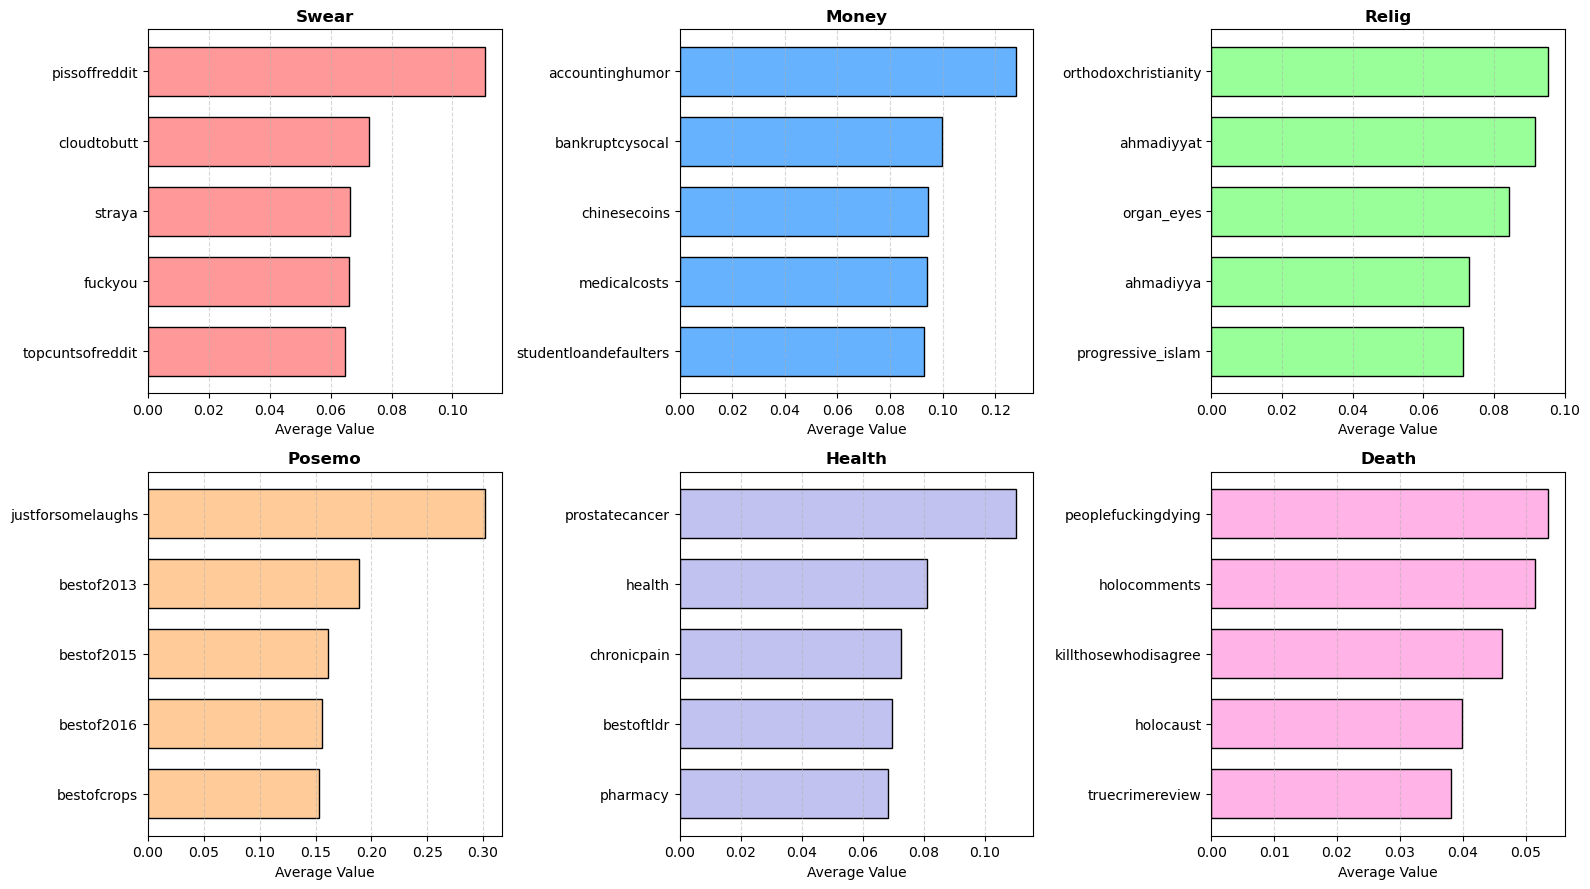

'images/top_5_subreddits_metrics.png'

In [66]:
target_metrics = [
    'LIWC_Swear', 'LIWC_Money', 'LIWC_Relig', 
    'LIWC_Posemo', 'LIWC_Health', 'LIWC_Death'
]

pl.plot_top_5_subreddits(avg_props_by_subreddit, target_metrics)

We can clearly see that for general textual properties (e.g. Health, Money, ...) there is a clear link between the subreddit title and the arguments of the outgoing posts. This incourage us to conduct an analysis using subreddit names as variables, still having in mind that this could be a biased analysis

# Clusters based on embeddings

### 1. Prepare Data
First, we'll use a function from our `utilis` module to separate the subreddit names from the embedding vectors and scale the vectors. This scaling step is essential for clustering algorithms to work correctly.

In [67]:
scaled_data, subreddit_labels = ut.prepare_embeddings_for_clustering(df_embeddings)

Data prepared: 51278 items, 300 features.


### 2. Find Optimal Number of Clusters (k)

We can't just guess how many clusters to create. We'll run a K-Means "Elbow Analysis" on a sample of the data.

**How to Read This Plot:** Look for the "elbow" of the arm, the point where the line starts to flatten out. This point is usually a good choice for the number of clusters. Adding more clusters after this point gives diminishing returns.

  Testing k=10...
  Testing k=50...
  Testing k=100...
  Testing k=150...
  Testing k=200...
  Testing k=250...
  Testing k=300...
  Testing k=500...


<Figure size 1000x600 with 0 Axes>

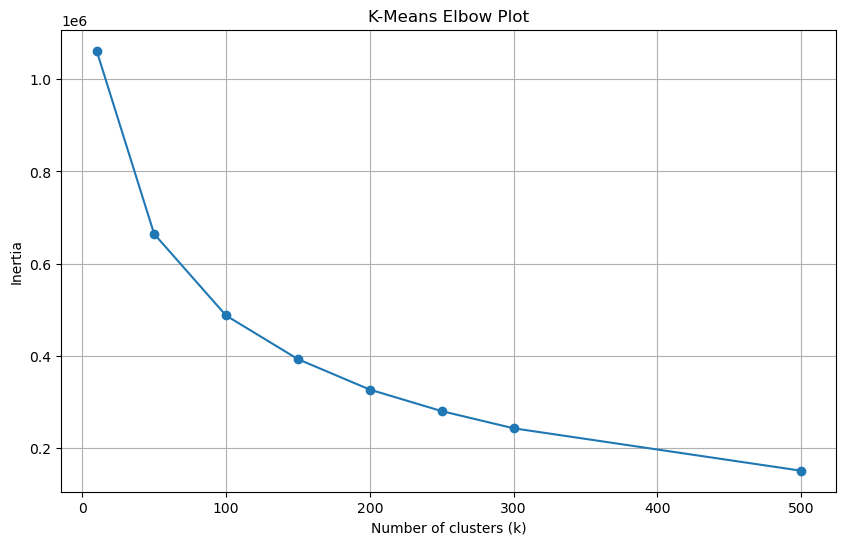

In [68]:
k_value_list=[10, 50, 100, 150, 200, 250, 300, 500]

elbow_df = ut.calculate_kmeans_elbow_wide(scaled_data, k_value_list, n_samples=5000)

pl.plot_kmeans_elbow(elbow_df)

### 3. Run Final Clustering & Visualization

Now, looking at the elbow plot above we can choose k=150. 

This function will:
1.  Run the final K-Means clustering on the **full 50k+ dataset**.
2.  Run **t-SNE**, a powerful algorithm that reduces the 300+ dimensions down to 2D (x, y) so we can plot them.
3.  Create an interactive scatter plot.

In [69]:
# This will take few minutes to run

N_CLUSTERS = 150  # number of clusters
MIN_SIZE = 300     # minimum size requirement of each cluster
PERPLEXITY = 50   

tsne_df, all_cluster_labels = ut.run_clustering_and_tsne(
    scaled_data, 
    subreddit_labels, 
    n_clusters=N_CLUSTERS,
    min_cluster_size=MIN_SIZE,
    perplexity=PERPLEXITY  
)

Running K-Means clustering with k=150 on 51278 items...
Finding valid clusters with > 300 members...
Found 21 valid clusters (out of 150) meeting the size criteria.
Running t-SNE with perplexity=50... (sampling 15000 items)
t-SNE complete.


### 4. Manually Label Clusters

Now we'll inspect the clusters. The cell below will get a sample of subreddits from all valid clusters.

In [70]:
valid_clusters = set(tsne_df['cluster'].astype(int))

full_df = pd.DataFrame({
    'subreddit': subreddit_labels,
    'cluster': all_cluster_labels
})
    
valid_df = full_df[full_df['cluster'].isin(valid_clusters)]
    
cluster_samples = ut.get_cluster_samples(
    valid_df['subreddit'].values,
    valid_df['cluster'].values,
    n_samples=100  # Show 100 samples from each
)
    
# Print the samples for inspection
for cluster_id, subs in cluster_samples.items():
        print(f"\n--- Cluster {cluster_id} ---")
        print(subs)


--- Cluster 0 ---
['bigbuttsluts', 'selftaught', 'gaydumpster', 'akmaker', 'csuci', 'joannanewsom', 'ladymras', 'elantra', 'boxy', 't_t', 'farcraft1', 'imaginaryhalflings', 'fifa17generatorcoins', 'bestofvic2015', 'fakten', 'wellbeing', 'maturebeauty', 'jimi_hendrix', 'nelsonnz', 'queensoflondon', 'prisontalk', 'mavic', 'paradoxes', 'familytravel', 'juuicyjasmine', 'sbcw', 'catskills', 'arkmutations', 'colt', 'secreat', 'langley', 'cincinnati_amiibo', 'tiphound', 'howtorpgpodcast', 'sneakersau', 'csclub', 'morninghair', 'capecodgaming', 'pixeljunkies', 'darkecho', 'tomatoesstandingup', 'dongdivison', 'notzen', '72hrs', 'instasound', 'taupybooks', 'babes_network', 'uofmemphis', 'restingbitchface', 'cwmgifs', 'unturnedtrades', 'sansastark', 'fcwmemes', 'dokkanbattletrades', 'motoxpure', 'vanillawowserver', 'blackadventist', 'eastofwest', 'obod', 'houstonphotography', 'hooligans', 'pokegoakron', 'jenniferhawkins', 'rpdrofficial', 'bourbonchicken', 'thebestlists', 'bravelysecond', 'bakhar

After looking at the example subreddit's names we can give meaningful labl to each cluster in order to have a better understanding on the plot

In [71]:
label_map = {
    # --- HIGH CLARITY: Distinct Topics ---
    '8': 'Geography, Local Locations & Geopolitics',
    '15': 'Viral Media, GIFs, & General Interest Images',
    '33': 'NSFW: Fetishes, Celebrities & Specific Content',
    '42': 'Business, Professional Development & Industry',
    '84': 'Gaming: Esports, Mods & RPGs',
    '89': 'Marketplaces, Trading (Gaming/Crypto) & LFG',
    '93': 'YouTubers, Streamers & Internet Personalities',
    '101': 'Political Ideology, Conspiracy & Activism',
    '107': 'NSFW: Hardcore Pornography & Adult Content',
    '108': 'Fantasy Art, Concept Art & My Little Pony Fandom',
    '149': 'Political News, Parties & Social Theory',
    '23': 'Self-Promotion, Spam & Adult Affiliate Marketing',

    # --- MEDIUM CLARITY: Broader Themes & Mixed Groups ---
    '0': 'Miscellaneous: Niche Interests, Gaming & NSFW',
    '1': 'Weapons, Darknet/Drugs & Tech Security',
    '18': 'Personal Stories, Support Groups & Reality TV',
    '21': 'Cryptocurrency, Tech & NSFW/Spam',
    '25': 'Niche Communities, Q&A & Text-Based Humor',
    '46': 'General Hobbies, Fitness & Lifestyle',
    '81': 'Creative Arts, Hobbies & Tech Support',
    '102': 'Pop Culture, Music, Animals & Entertainment',
    '142': 'Miscellaneous International & NSFW'
}

# --- Now, we plot using the assigned labels ---

pl.plot_labeled_cluster_map(tsne_df, label_map)

[![Clusters](images/screenshot_of_interactive_plots/cluster.png)](https://github.com/epfl-ada/ada-2025-project-djnpsgroup2025/blob/main/images/screenshot_of_interactive_plots/cluster.png?raw=true)

From this interactive plot we can see that many clusters are not specifically related to one single topic while others strictly relate to one. Let's procede to analyse geographical connections.

# Country analysis

To understand country-specific interactions, we first needed to identify which subreddits belong to which countries:

- Generation: An initial automated mapping was created (in filter_countries_expanded.py). 
To map subreddits to countries, we developed a Python pipeline RapidFuzz for string similarity. We utilized a comprehensive dictionary mapping native names, demonyms, and major cities to standardized country labels. The matching logic operated hierarchically: first prioritizing exact token matches, then identifying specific substrings at the start or end of subreddit names, and finally applying fuzzy matching with a strict similarity threshold (>90) to capture variations.
This found obvious matches (e.g., brasilonreddit -> Brazil) but also incorrect ones (e.g., askinsurance -> France).

- Verification: This initial list was manually reviewed, and each match was either "approved" or "rejected".


### 1. Map subreddits to the country they belong to and look at their average properties
Here we can conduct a similar analysis to the previous one but just considering country-related subreddit 

In [72]:
# At the beginning we loaded all the posts containg a country related subreddit either as source or as target
# Here we keep only the posts with a source subreddit categorized as a country
df_post_source_country = df_post_with_1_country.dropna(subset=['source_country'])

country_post_counts = df_post_source_country["source_country"].value_counts()

min_posts_threshold = 10 # Keep only countries with at least 10 posts 
valid_countries = country_post_counts[country_post_counts >= min_posts_threshold].index

print(f"Found {len(valid_countries)} countries with at least {min_posts_threshold} posts.")

avg_props_by_country = (
    df_post_source_country[df_post_source_country["source_country"].isin(valid_countries)]
    .groupby("source_country")[ut.post_props_cols] 
    .mean()
)

Found 109 countries with at least 10 posts.


In [73]:
metric = "LIWC_Relig"
title="Average Religion Sentiment by Country"

pl.plot_countries_by_metric(avg_props_by_country, metric, title)

[![Average Religion](images/screenshot_of_interactive_plots/religion.png)](https://github.com/epfl-ada/ada-2025-project-djnpsgroup2025/blob/main/images/screenshot_of_interactive_plots/religion.png?raw=true)

The ranking of countries by "Religion" sentiment provides strong validation for the methodology of classifying subreddits by country using the name. The results align with real-world geopolitical and cultural realities:

The highest-ranked countries (Sri Lanka, Israel, Mongolia, Saudi Arabia and Bangladesh) are nations where religion is either a central pillar of daily life or a primary driver of political discourse. 

It is important to acknowledge that specific rankings may appear as outliers due to the inherent nature of the data source

For countries in the middle-end of the ranking, the difference in scores is often microscopic (e.g., a difference of 0.0001), that's why we only considered the first 70 countries in this plot. In these cases, the specific ranking order is less meaningful and likely fluctuates based on random noise or transient topics.
However, the top-ranked nations show scores that are distinctively higher—often double or triple the average of the bottom tier. Despite the raw numbers being small, this relative difference is statistically significant. It confirms that for these specific communities, religion is not just background noise but a recurring and measurable theme of the conversation.

### 2. Country interactions

Let's look at the raw post count originating from each country's subreddits to understand general activity levels. Here we are using the larger list of country mappings that have not been manually approved yet.

In [74]:
display(country_post_counts.head(20))

source_country
USA               18283
Canada             4490
Japan              2600
India              2283
Australia          1566
France             1510
Italy              1423
United Kingdom     1178
Ireland            1155
Brazil             1081
Norway              835
Netherlands         782
China               748
Sweden              686
Portugal            681
Argentina           677
Germany             573
Oman                553
Russia              553
Romania             534
Name: count, dtype: int64

We can clearly see that there is a big difference in the number of posts associated to each country so it is recommended to normalized every country by the number of posts

In [75]:
df_final= ut.calculate_normalized_interactions(country_post_counts, df_post_between_countries)

display(df_final[['Country_A', 'Country_B', 'n_interactions', 'norm_log']].head(20))

,Country_A,Country_B,n_interactions,norm_log
585,Israel,Palestine,122,19.204646
786,Russia,Ukraine,78,11.553670
217,Canada,USA,104,10.365406
490,India,Pakistan,74,9.467253
823,USA,United Kingdom,78,7.897759
168,Brazil,Portugal,49,6.555384
557,Iran,USA,63,6.403401
429,Germany,USA,59,5.993109
577,Ireland,USA,56,5.670865
219,Canada,United Kingdom,42,4.859554


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
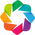

:Chord   [source,target]   (value)

In [76]:
viz=pl.chord_plot(df_final)
viz

[![Chord plot](images/screenshot_of_interactive_plots/chord.png)](https://github.com/epfl-ada/ada-2025-project-djnpsgroup2025/blob/main/images/screenshot_of_interactive_plots/chord.png?raw=true)

Based on these results, the mappings appear to be highly relevant and effective.

The top-ranking interactions are not random. They clearly reflect significant real-world relationships:

Geographic & Cultural Neighbors: The high volume of interactions between the United States and Canada, as well as between India and Pakistan, highlights strong regional and cultural connections (and rivalries).

Geopolitical Hotspots: The prominent ranking of pairs like Iran and the United States, and Israel and Palestine, strongly indicates that the mappings are successfully capturing communities engaged in intense, real-world geopolitical discourse.

Linguistic & Historical Ties: The presence of USA/UK and Brazil/Portugal further validates the mappings by identifying well-known historical and linguistic connections.

In conclusion, the fact that the aggregated data mirrors known global relationships so closely serves as a strong validation. It shows the approved mapping list is successfully identifying distinct country-specific communities and capturing their most significant online interactions.

### 3. Faction Analysis using Embeddings
We have previously seen that creating cluster using the embedding can lead to confuse results, that's why this analysis attempts to find "strict" subreddits (those that are semantically closer to their own country's subreddits than to any other) and their closest neighbors based on embedding distance. 


In [77]:
# find only the embedding of country-related subreddits
df_embeddings_countries=dl.filter_embeddings_by_country(df_embeddings, df_countries)

# keep only the strict links
df_strict = ut.find_strict_subreddits(df_countries, df_embeddings_countries)

print(f"Found {len(df_strict)} 'strict' subreddits.")
print("\nTop 10 countries by number of 'strict' subreddits:")
display(df_strict.groupby("country").size().sort_values(ascending=False).head(10))

Filtering embeddings...
Embedding filtering complete.
Found 122 'strict' subreddits.

Top 10 countries by number of 'strict' subreddits:


country
Israel         4
Ireland        4
Sweden         3
New Zealand    3
Ukraine        3
Oman           3
Chile          3
Libya          2
Ghana          2
Slovenia       2
dtype: int64

In [78]:
# we search for the closest subreddit (cosine similarity on embedding vectors) categorized as a different country 
closest_df = ut.find_closest_dissimilar_subreddits(df_strict, df_embeddings)
print("\nClosest subreddits from different countries (based on embedding distance):")
display(closest_df.head(10))


Closest subreddits from different countries (based on embedding distance):


,subreddit,country,most_similar_subreddit,most_similar_country,similarity_score
0,nomansskythegame,Oman,greenlantern,Greenland,0.286006
1,sweden,Sweden,brasilivre,Brazil,0.310327
2,romania,Romania,chile,Chile,0.345627
3,ireland,Ireland,israel,Israel,0.328369
4,newzealand,New Zealand,lebanon,Lebanon,0.404871
5,ukraina,Ukraine,privacyrus,Cyprus,0.628723
6,israel,Israel,armenia,Armenia,0.584802
7,svenskpolitik,Sweden,brasilivre,Brazil,0.370492
8,puertorico,Puerto Rico,bulgaria,Bulgaria,0.286435
9,guineapigs,Guinea,malta,Malta,0.615593


As we can see performing the analysis on embedding distance is not leading us to correct results even when considering only subreddit strongly related to countries. The closest subreddit always belong to a country that is not geographical/cultural/political related.

### 4. Faction Analysis using Positive Posts

This is a more robust analysis. It builds a network graph where countries are nodes. The edge weight is based on the number of positive posts, normalized by the total activity of each country. This normalization prevents large countries (like Canada or USA) from dominating all factions simply due to high post volume.

To detect geopolitical factions, we constructed a weighted graph based on positive subreddit interactions, employing a normalization strategy where edge weights were defined as the interaction count divided by the product of both countries' total activity to correct for volume disparities. We then applied the Greedy Modularity Maximization algorithm (via networkx) to partition the network into communities. This algorithm iteratively merges groups of nodes to maximize the density of connections within communities relative to a random null model. The resulting partitions reveal "factions" of nations that share significantly higher mutual positive engagement than expected by chance.

In [39]:
factions_summary_norm, factions_df_norm = ut.detect_normalized_factions(df_post_between_countries)
pl.plot_faction_world_map(factions_df_norm, title="World Map of Factions")

[![World Map Factions](images/screenshot_of_interactive_plots/worldmap.png)](https://github.com/epfl-ada/ada-2025-project-djnpsgroup2025/blob/main/images/screenshot_of_interactive_plots/worldmap.png?raw=true)

There are few conclusion we can state from this plot:

- Significant Data Gaps: The vast grey areas in Central Africa highlight a severe "digital divide," confirming Reddit’s bias toward English-speaking and Western-aligned nations; countries that are colored but have low post counts are statistically unstable and may be grouped based on "noise" rather than deep cultural ties.

- The "Eurasian" Conflict Zone: Russia anchors a massive Blue bloc that pulls in Eastern Europe, suggesting that political discourses mathematically isolate these nations from the rest of the European cluster.

- The Commonwealth: The emergence of a specific cluster (Red) grouping India, South Africa, Nigeria, Pakistan and Australia suggests that historical British colonial ties create a persistent "digital heritage." Despite vast geographic distances, these nations share an institutional and linguistic framework (English as a bridge language).

- Fractured Americas: The plot reveals a clear fracture between North and South America; while the Northern nations (USA, Canada, Mexico) form a cohesive unit integrated into the global mainstream, South America fragments, with the "Southern Cone" (Argentina, Chile, Uruguay, Paraguay and Bolivia) isolating itself into a separate faction.
  
- Linguistic connections: A link between Brazil-Portugal is evidence on how much the linguisitc feature mtter when using the hyperlink metric for the creation of the factions


Now, we analyze how factions change from year to year using the source-normalized method.

In [79]:
df_post_between_mapped = ut.map_countries_to_posts(df_post_between_countries, df_countries, period="Y")

y_factions_norm_df = ut.analyze_source_normalized_factions_over_time(df_post_between_mapped)
pl.plot_faction_evolution(y_factions_norm_df)

[![Sankey](images/screenshot_of_interactive_plots/sankey.png)](https://github.com/epfl-ada/ada-2025-project-djnpsgroup2025/blob/main/images/screenshot_of_interactive_plots/sankey.png?raw=true)

Of course from this plot we can't understand which country belong to which faction and also the faction's number and color are just used to distinguish them. The plot is useful to visually understand how the states migrate between the factions, especially during the lat year.

In order to have a better perspective on the countries that switched group we can analyze the evolution using a finer split of time and then look at the most stable couples

Which countries consistently appear in the same faction together over time? A high fraction means a strong, stable bond.

In [80]:
df_post_between_mapped = ut.map_countries_to_posts(df_post_between_countries, df_countries, period="Q")

q_factions_norm_df = ut.analyze_source_normalized_factions_over_time(df_post_between_mapped)
stable_pairs_norm = ut.find_stable_pairs(q_factions_norm_df)
print("Most Stable Country Pairs (Source-Normalized):")
display(stable_pairs_norm.head(15))

Most Stable Country Pairs (Source-Normalized):


,country1,country2,quarters_together,fraction_quarters_together
0,Russia,Ukraine,13,0.928571
1,North Korea,South Korea,11,0.785714
2,India,Pakistan,11,0.785714
3,Argentina,Uruguay,9,0.642857
4,Brazil,Portugal,9,0.642857
5,Malaysia,Singapore,9,0.642857
6,Norway,Sweden,9,0.642857
7,Indonesia,Malaysia,9,0.642857
8,Armenia,Turkey,9,0.642857
9,Denmark,Sweden,9,0.642857


We have a validation of the results obtained with the individual analysis but from a different persective


Let's visualize the results for some countries. 

An heatmap indicating the number of quarters spent together is a good choice, having in mind that of course the matrix is symmetric and reach the maximum along the main diagonal.
We are interested in the brighter squares outside of the diagonal

In [81]:
target_countries = [
    'USA', 'Canada', 'Japan', 'India', 'Australia', 'France', 'Italy',
    'United Kingdom', 'Ireland', 'Brazil', 'Norway', 'Netherlands', 'China',
    'Sweden', 'Portugal', 'Argentina', 'Germany', 'Russia', 'Romania',
    'Greece', 'Mexico', 'Iran', 'New Zealand', 'Israel', 'Serbia',
    'Denmark', 'Philippines', 'Peru', 'Estonia', 'Poland', 'South Korea',
    'Finland', 'Ukraine', 'Spain', 'Singapore', 'Turkey',
    'Croatia', 'Latvia', 'Indonesia', 'Belgium', 'Austria', 'Colombia',
    'Pakistan', 'Malaysia', 'Palestine', 'Switzerland', 'Iceland', 'Chile'
    ]

pl.heatmap_co_occurrence(target_countries, q_factions_norm_df)

[![Heatmap](images/screenshot_of_interactive_plots/heatmap.png)](https://github.com/epfl-ada/ada-2025-project-djnpsgroup2025/blob/main/images/screenshot_of_interactive_plots/heatmap.png?raw=true)

#### Loyalty Score
Which countries tend to switch factions most often? A low score means the country frequently changes its primary allies.

In [82]:
loyalty_norm = ut.calculate_loyalty_scores(q_factions_norm_df)
print("Most 'Loyal' Countries (Most likely to stay with the same allies, Score < 1.0):")
display(loyalty_norm.sort_values("loyalty_score", ascending=False).head(15))

Most 'Loyal' Countries (Most likely to stay with the same allies, Score < 1.0):


,country,loyalty_score,total_quarters
0,Russia,0.928571,14
1,Ukraine,0.928571,14
2,Armenia,0.818182,11
3,Nepal,0.800000,10
4,Pakistan,0.785714,14
5,India,0.785714,14
6,South Korea,0.785714,14
7,Portugal,0.750000,12
8,Bolivia,0.750000,4
9,Paraguay,0.750000,4


They list is obviously guided by the countries who spent most time in a faction with another one

Finally, let's visualize the overall network. This graph shows the net sentiment (positive posts - negative posts) between all countries.

- **Nodes** are colored by the faction they belong to (from the normalized analysis).
- **Green Edges** = Net Positive Interaction
- **Red Edges** = Net Negative Interaction
- **Edge Width** = Total number of posts (log-scaled)

In [22]:
pl.plot_signed_network(
    df_post_between_countries, 
    factions_df_norm, 
    title="Signed Network of Country Interactions"
)

[![Signed Network](images/screenshot_of_interactive_plots/signed_network.png)](https://github.com/epfl-ada/ada-2025-project-djnpsgroup2025/blob/main/images/screenshot_of_interactive_plots/signed_network.png?raw=true)

We can clearly see that biggest states are in the middle and are the vertices of many edges reflecting their user's community activity.

The block of states belonging to the biggest faction create an intricated network in the middle of the graph. 
In contrast smaller countries are more isolated and they have very few interactions (edges are thinner)

Overall the meajority of the edges are green showing that our dataset is clearly unbalanced towards positive labelled posts


### 5. Shortest path analysis

To fully understand the relationships between the different countries we also conducted an analysis based on shortest path. We computed this metric basing on the number of hyperlink going from one country to another
# SIMON ADD MORE TO EXPLAIN THIS PART BETTER

Here we import the pre computed dataset to show some results

In [83]:
COUNTRY_PATHS_OUTPUT = "data/country_shortest_paths_output.csv"
df_country_paths = pd.read_csv(COUNTRY_PATHS_OUTPUT)
df_relevant_rows = df_country_paths[
        (df_country_paths['source_country'] != df_country_paths['target_country']) & (df_country_paths['shortest_path_length'] < np.inf)
    ]
print("\n--- Shortest Paths Between Countries (Top 10) ---")
display(df_relevant_rows.head(10))


--- Shortest Paths Between Countries (Top 10) ---


,source_country,target_country,shortest_path_length
9,Pakistan,India,4.545455
11,India,Pakistan,5.000000
12,Israel,"Palestine, State of",5.882353
14,Brazil,Portugal,5.882353
15,United Kingdom,Ireland,5.882353
16,"Palestine, State of",Israel,5.882353
18,India,Nepal,6.666667
20,New Zealand,Australia,7.142857
22,Canada,India,8.104396
25,Japan,India,8.571429


In [84]:
pl.plot_MDS_shortest_path(df_country_paths)

[![MDS](images/screenshot_of_interactive_plots/mds.png)](https://github.com/epfl-ada/ada-2025-project-djnpsgroup2025/blob/main/images/screenshot_of_interactive_plots/mds.png?raw=true)

This plot visualizes the "digital geography" of nations based on the shortest path length of subreddit hyperlinks. Dots that are close together share short, direct paths in the network, while distant dots are "digitally isolated."

The visualization reveals a striking Core-Periphery structure that mirrors the not balanced adoption of Reddit over all the states:

The Dense Core: The center of the plot contains a tightly packed, overlapping cluster of nations. These represent the "Grand Central Stations" of the major geopolitical powers and Western nations where Reddit usage is highest. Because these countries are hyper-connected (linking to almost everyone), the algorithm pulls them all into the center of gravity. The distance between any two of these nations is extremely short.

The External Ring: Surrounding the core is a distinct, sparse ring of nations (e.g., Bhutan, Benin, Martinique, Comoros). These countries are pushed to the edges because they are "digitally distant." They likely have very few incoming or outgoing links, meaning a user would have to traverse many hops to get from a "Core" country to one of these "Ring" countries.

The Reddit Bias: This specific topology highlights the demographic bias of the platform. The countries in the external ring generally have lower Reddit penetration, non-English dominant user bases, or lower internet access. They exist as "satellite communities"—isolated outposts that connect to the global conversation through weak links, rather than being integrated into the central web of discourse.

# Global Conditional Probability of Reciprocity

In simple terms, we want to answers the question:
> "If Country A posts to Country B, what is the probability that Country B will post back to Country A within 7 days?"

## Function Analysis: `response_global`

### 1. Preparation and Filtering

* **Clean:** Drops any rows where the source or target country is missing, and converts the `TIMESTAMP` column into a proper datetime format.
* **Create `pair_key`:** To analyze a pair like (Italy, France), it needs to group all `Italy -> France` and `France -> Italy` interactions together. It uses a `frozenset` because `frozenset({'Italy', 'France'})` is the *same* as `frozenset({'France', 'Italy'})`. This lets it group all interactions for a pair, regardless of direction.
* **Filter `valid_pairs`:** It counts how many interactions each pair has. If a pair only has one post (e.g., Italy posted to France, but France *never* posted), it's impossible to measure reciprocity. So, it only keeps pairs with 2 or more interactions.

### 2. The Deterministic Logic 

* **Loop:** It loops through every `valid_pair` (e.g., the `{'Italy', 'France'}` pair).
* **Find the "True" Initiator:** For each pair, it gets all their interactions and finds the **very first post** (`first_interaction = df_pair.iloc[0]`).
* **Assign Roles:** Based on that *first post*, it permanently assigns the roles:
    * `country_A` = The `SOURCE_COUNTRY` of that very first post (The "Initiator").
    * `country_B` = The `TARGET_COUNTRY` of that very first post (The "Responder").
* **Separate Data:** It then creates two new DataFrames:
    * `df_A_to_B`: All posts where the Initiator (A) posted to the Responder (B).
    * `df_B_to_A`: All posts where the Responder (B) posted back to the Initiator (A).

### 3. The 7-Day Window (The `merge_asof`)

* **`pd.merge_asof`:** This is a powerful time-series function. It takes *every single post* from `df_A_to_B` (an "initiation") and searches in `df_B_to_A` to find the **first response** that happened *after* it (`direction='forward'`).
* **Calculate `response_time`:** It creates a new column by subtracting the initiation time from the response time.
* **Check Window:** It checks if this `response_time` is less than or equal to 7 days.
* **Count Totals:**
    * `total_initiators_global` is incremented by the total number of initiations (the length of `df_A_to_B`).
    * `total_responses_global` is incremented only by the number of responses that were `True` for the 7-day check.

### 4. Final Calculation

* It divides `total_responses_global` by `total_initiators_global` to get the final conditional probability (e.g., `P(B->A | A->B)`).
* It prints this final result.

In [ ]:
initiators, responses = ut.response_global(df_post_between_countries)

fig = pl.funnel_graph_global(initiators, responses)
fig.show()

DataFrame ready. Analyzing 552 pairs.


Analyzing pairs: 100%|██████████| 552/552 [00:00<00:00, 568.06it/s]



--- Global Reciprocity Analysis ---
Total 'initiator' interactions (A->B) analyzed: 1614
Total responses (B->A) within 7 days: 311
GLOBAL Conditional Probability P(B->A | A->B in 7d): 19.27%


[![Funnel Global](images/screenshot_of_interactive_plots/funnel1.png)](https://github.com/epfl-ada/ada-2025-project-djnpsgroup2025/blob/main/images/screenshot_of_interactive_plots/funnel1.png?raw=true)

We now repeat the same analysis but only considering interaction between subreddits (different) belonging to the same country. Our goal is to compare the previous rensponse rate with the following one to assess when is more likely to obtain an answer in the 7 days window

In [50]:
intra_initiators, intra_responses = ut.response_intra_country(df_post_between_countries)

fig_intra = pl.funnel_graph_intra_country(intra_initiators, intra_responses)
fig_intra.show()

Found 9683 intra-country interactions (between different subreddits).
Analyzing 860 unique subreddit pairs.


Analyzing subreddit pairs: 100%|██████████| 860/860 [00:01<00:00, 671.71it/s]



--- Global INTRA-COUNTRY Reciprocity Analysis ---
Total 'initiator' interactions (SubA -> SubB) analyzed: 3811
Total responses (SubB -> SubA) within 7 days: 302
GLOBAL Conditional Probability P(SubB->SubA | SubA->SubB in 7d): 7.92%


[![Funnel Intra-Country](images/screenshot_of_interactive_plots/funnel2.png)](https://github.com/epfl-ada/ada-2025-project-djnpsgroup2025/blob/main/images/screenshot_of_interactive_plots/funnel2.png?raw=true)

Our analysis reveals a surprising trend: the probability of receiving a reciprocal response within 7 days is significantly higher for international interactions (19%) than for domestic ones (8%). This suggests that cross-country posts are often purposeful engagements—such as cultural questions or political debates—that inherently demand a reply. Conversely, domestic subreddits appear to function more as isolated silos or broadcast channels where content is consumed passively, leading to lower dialogue between communities within the same nation.

# Linguistic Style Mirroring Test

We want to answer the question:
> "When a post (A) triggers a reply (B), does the *style* of the reply (B) unconsciously mimic the *style* of the original post (A)?"

To prove this, we can't just measure the similarity of reply pairs. We need to prove that they are *more similar than they would be by pure chance*. This requires a:

1.  **Test Group:** A list of similarity scores from *actual* reciprocal pairs (A replied to B).
2.  **Control Group:** A list of similarity scores from *randomly selected* pairs (X and Y, who have no connection).
3.  **Comparison:** A statistical test (like a T-test) to see if the Test Group's similarity is significantly higher than the Control Group's.

This experimental design is complex. To keep the code clean and readable, we split the logic:

* **`find_reciprocity_pairs_and_similarity()` (The "Helper" Function):** This function has one very specific and difficult job: to find every valid `A -> B => B -> A` interaction and return the list of their similarity scores. This will be our **Test Group**.
* **`response_similarity()` (The "Main" Function):** It defines the experiment, calls the helper function to get the Test Group, creates the **Control Group** itself, and then performs the final statistical comparison and visualization.

---
## The Helper Function: `find_reciprocity_pairs_and_similarity`

This function builds our **Test Group**.

1.  **Define Triggers (A) and Responses (B):**
    * It loads the `matches_csv` to get a list of "country subreddits."
    * A **"Trigger" (A)** is defined as any *non-country* subreddit posting *to* a *country* subreddit.
    * A **"Response" (B)** is defined as a *country* subreddit posting *to* a *non-country* subreddit.

2.  **Index Responses (An Optimization):**
    * Instead of re-scanning the entire list of responses for every single trigger, it creates a `response_lookup` dictionary. This index allows it to instantly find all potential responses for a given pair (e.g., all posts from `'r/italy'` to `'r/formula1'`).

3.  **Iterate and Find Pairs:**
    * It loops through *every single Trigger (A)* post.
    * For each trigger (e.g., `r/formula1 -> r/italy`), it calculates the 7-day window *from that post's timestamp*.
    * It uses the `response_lookup` to find all matching Responses (B) (e.g., `r/italy -> r/formula1`) that fall *within that 7-day window*.

4.  **Calculate Similarity:**
    * If valid responses are found, it takes the **first** one (`.iloc[0]`).
    * It gets the "style vector" (the list of 12 LIWC/VADER features) for the trigger post (A) and the response post (B).
    * It calculates the **cosine similarity** between these two vectors.
    * This similarity score is added to the `similarity_scores` list.

This function returns the complete `similarity_scores` list, which is our **Test Group**.

---
## The Main Function: `response_similarity`

This function takes the Test Group from the helper and runs the full experiment.

1.  **Define Style Vector:** It defines `style_features_list`. This is a crucial choice: we are *only* testing style (tone, pronouns, etc.), not the *topic* (work, money, etc.).
2.  **Prepare Data:** Filters it down to only the columns needed for the style vectors.
3.  **Get Test Group:** It calls `find_reciprocity_pairs_and_similarity()` to get the list of scores (`reciprocity_similarities`).
4.  **Create Control Group:**
    * It counts how many scores are in the Test Group (e.g., `N = 1,500`).
    * It then creates a `baseline_similarities` list by **randomly sampling** `N` pairs of posts from the *entire dataset* and calculating their similarity. This list represents the similarity that occurs "by pure chance."
5.  **Run Statistical Tests:**
    * It compares the two lists (`Reciprocal` vs. `Random`) using a T-test and a Mann-Whitney U-test.
    * It specifically uses `alternative='greater'` to test our hypothesis: "Is the Reciprocal group's similarity *greater than* the Random group's?"
6.  **Interpret Results & Plot:**
    * It checks the **p-value**. A `p < 0.05` is considered a **significant result**, meaning the similarity we see in the Test Group is not just a random fluke. This provides evidence for our "Stylistic Mirroring" hypothesis.
    * It then plots both distributions on a KDE plot, allowing us to *visually* confirm if the Reciprocal group's curve is shifted to the right (more similar) than the Random group's curve.

Analysis DataFrame ready.


100%|██████████| 44328/44328 [01:34<00:00, 468.99it/s] 



--- Starting Baseline Analysis (Control Group) ---
Creating 2130 random post pairs for comparison...


100%|██████████| 2130/2130 [00:00<00:00, 9872.49it/s]


Baseline analysis complete.

--- Statistics (Test Group: Reciprocal) ---
count    2130.000000
mean        0.269752
std         0.613529
min        -0.998335
25%         0.000000
50%         0.000000
75%         0.986879
max         1.000000
Name: Reciprocal, dtype: float64

--- Statistics (Control Group: Random) ---
count    2130.000000
mean        0.065319
std         0.547747
min        -0.986255
25%         0.000000
50%         0.000000
75%         0.028886
max         1.000000
Name: Random, dtype: float64

--- T-Test (Reciprocal > Random) ---
T-statistic: 11.4716
P-value: 0.0000

--- Mann-Whitney U Test (Reciprocal > Random) ---
U-statistic: 2772109.0000
P-value: 0.0000

--- Test Interpretation ---
SIGNIFICANT RESULT (p < 0.05):
The linguistic style of reciprocal response posts is SIGNIFICANTLY MORE SIMILAR
than that of two random posts. There is evidence of stylistic mirroring.


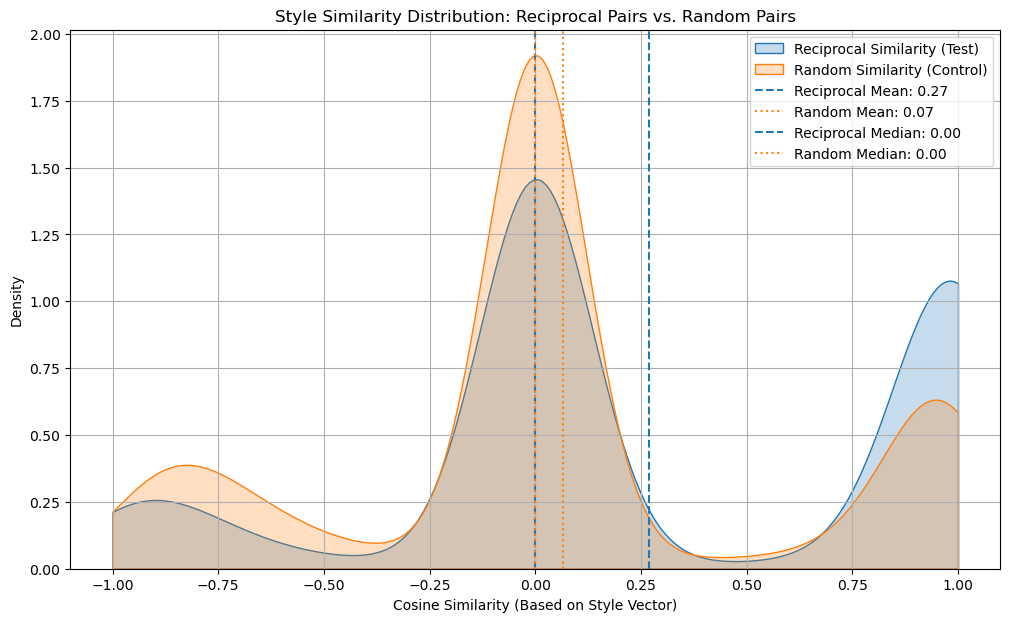

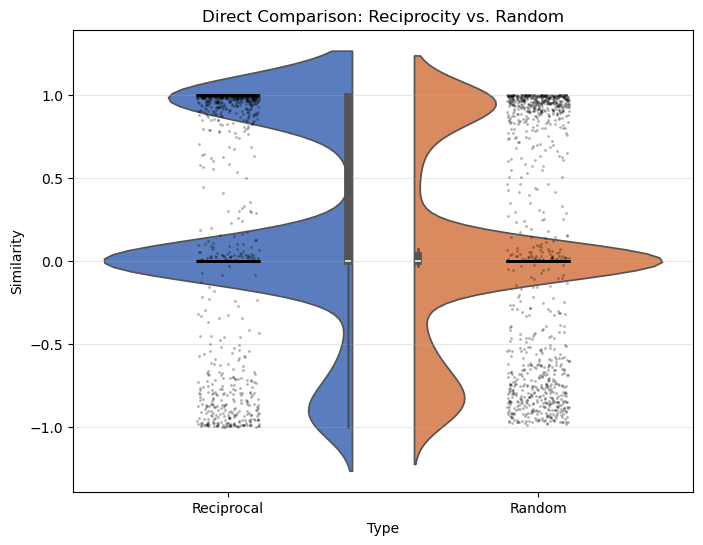

In [51]:
ut.response_similarity(df_posts, df_countries)

### Statistical Interpretation of Results

The t-test ($p < 0.05$) confirms that the mean style similarity for **Reciprocal pairs ($M=0.273$)** is **significantly higher** than for **Random pairs ($M=0.07$)**.

This difference in means is particularly notable because the **median similarity for both groups is identical (0.00)**.

The Kernel Density Estimate (KDE) plot explains this:

* The distribution for the Reciprocal (Test) group is **bimodal**.
* It shares the large central peak at 0.00 with the control group, indicating that the *majority* of interactions in both groups show no stylistic matching.
* However, the Reciprocal group features a **second, distinct peak near +1.0** (high similarity) which is absent in the control group.

### Conclusion

The data does not suggest that *all* reciprocal interactions involve mirroring.

Instead, it provides strong evidence that a **distinct subgroup of reciprocal posts exhibits extreme stylistic matching**. This specific subgroup is responsible for "pulling" the test group's mean significantly higher, confirming the existence of a powerful, though not universal, mirroring behavior.

# Sport Analysis

This analysis answers the question: **"Which single sport is the most popular (has the most interactions) in each country?"**

### 1. Load Sport Analysis Data

We'll load the (`df_country_sports`) obteined with `filter_sports.py`. 

This file is special: an interaction can be `Country -> Sport` or `Sport -> Country`. This means a single row might have a `NaN` value in either `SOURCE_COUNTRY` or `TARGET_COUNTRY`.


In [85]:
from src.data.filter_sports import filter_sports as flt_sports

In [53]:
sport_matches = flt_sports(df_post_with_1_country, COUNTRY_FILE, "data/")

100%|██████████| 12025/12025 [00:00<00:00, 27024.36it/s]


In [54]:
df_post_with_1_country.head(10)

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,POST_ID,TIMESTAMP,LINK_SENTIMENT,num_chars,num_chars_no_space,frac_alpha,frac_digits,frac_upper,...,LIWC_Home,LIWC_Money,LIWC_Relig,LIWC_Death,LIWC_Assent,LIWC_Dissent,LIWC_Nonflu,LIWC_Filler,source_country,target_country
0,inlandempire,bikela,1u4qlzs,2014-01-01 14:54:35,1,85.0,85.0,0.752941,0.023529,0.082353,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Finland,NaN
1,gfycat,india,1u5df2s,2013-12-31 22:27:50,1,2849.0,2467.0,0.704107,0.007371,0.038610,...,0.000000,0.007042,0.000000,0.000000,0.000000,0.000000,0.004695,0.002347,NaN,India
2,connecticut,ctbeer,1u64lgs,2014-01-01 09:59:45,1,1007.0,895.0,0.735849,0.029791,0.073486,...,0.000000,0.006369,0.000000,0.000000,0.006369,0.000000,0.000000,0.000000,USA,NaN
3,denverbroncos,seahawks,1u6gp2s,2014-01-01 13:31:17,1,839.0,688.0,0.747318,0.015495,0.047676,...,0.000000,0.006135,0.006135,0.000000,0.006135,0.000000,0.000000,0.000000,USA,NaN
4,australia,sydney,1u71zd,2014-01-01 17:24:46,-1,2547.0,2158.0,0.801335,0.005104,0.009423,...,0.002364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Australia,Australia
5,minnesotavikings,nfl,1u73nms,2014-01-01 18:13:47,1,423.0,359.0,0.773050,0.007092,0.028369,...,0.000000,0.013889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,USA,NaN
6,basicincome,canadapolitics,1u7bn7s,2014-01-01 23:34:07,1,4314.0,3865.0,0.710478,0.022949,0.041725,...,0.002793,0.029330,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,Canada
7,blackfellas,changemyview,1u7rbns,2014-01-02 00:33:35,1,2564.0,2187.0,0.790562,0.003510,0.015601,...,0.002427,0.002427,0.000000,0.002427,0.000000,0.004854,0.000000,0.004854,Greece,NaN
8,alaskanmalamute,dogtraining,1u8eyzs,2014-01-02 20:02:52,1,403.0,345.0,0.779156,0.004963,0.024814,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014085,USA,NaN
9,chromecast,android,1u8l98s,2014-01-02 08:50:49,1,471.0,397.0,0.777070,0.004246,0.027601,...,0.000000,0.022989,0.000000,0.000000,0.000000,0.000000,0.011494,0.011494,Italy,NaN


In [ ]:
df_country_sport = df_post_with_1_country.copy()
df_country_sport["SPORT_SOURCE"] = df_country_sport["SOURCE_SUBREDDIT"].map(sport_matches)
df_country_sport["SPORT_TARGET"] = df_country_sport["TARGET_SUBREDDIT"].map(sport_matches)


cond_1 = (df_country_sport['SPORT_SOURCE'].notna()) & (df_country_sport['target_country'].notna())

cond_2 = (df_country_sport['SPORT_TARGET'].notna()) & (df_country_sport['source_country'].notna())

df_country_sport = df_country_sport[cond_1 | cond_2]

### 2. Clean the dataset 

Create one 'Country' column
It takes the value from 'SOURCE_COUNTRY'. If that is NaN, it fills it with the value from 'TARGET_COUNTRY'.
Same with 'Sport'.

In [56]:
df_analysis = df_country_sport.copy()
df_analysis['Country'] = df_analysis['source_country'].fillna(df_analysis['target_country'])

df_analysis['Sport'] = df_analysis['SPORT_SOURCE'].fillna(df_analysis['SPORT_TARGET'])

### 3. Agregate interactions 

We group by the new clean columns and count the occurrences

In [57]:
agg_interactions = df_analysis.groupby(['Country', 'Sport']).size().reset_index(name='total_interactions')

### 4. Find the Top Sport for Each Country 

In [ ]:
idx_of_max_per_group = agg_interactions.groupby('Country')['total_interactions'].idxmax()

df_top_sport_per_country = agg_interactions.loc[idx_of_max_per_group]

df_top_sport_per_country = df_top_sport_per_country.sort_values('total_interactions', ascending=False)

print("\n--- Top Sport per Country (Ranked by Interaction Count) ---")
print(df_top_sport_per_country)


--- Top Sport per Country (Ranked by Interaction Count) ---
             Country              Sport  total_interactions
341              USA  American Football                 573
59            Canada             Hockey                 128
161          Ireland             Soccer                  92
253             Oman            eSports                  88
322            Spain             Soccer                  88
..               ...                ...                 ...
234   Norfolk Island             Soccer                   1
236      North Korea            eSports                   1
237  North Macedonia             Soccer                   1
257           Panama             Soccer                   1
198          Lebanon          Formula 1                   1

[92 rows x 3 columns]


In [59]:
pl.plot_sunburst(df_top_sport_per_country)

[![Sport Sunburst](images/screenshot_of_interactive_plots/sport.png)](https://github.com/epfl-ada/ada-2025-project-djnpsgroup2025/blob/main/images/screenshot_of_interactive_plots/sport.png?raw=true)

The results highlight the unique demographic distortions of the platform:

- The Big Three: The ecosystem is dominated by Soccer (Global), American Football (US-centric), and Esports.
- The Reddit Factor: While Esports are niche in traditional media, here they are a titan. This reflects Reddit's core demographic: tech-savvy, young, and digital-native.
- Regional Dominance:In Europe almost entirely unified under the banner of Soccer; in USA there is a stronghold for American Football (NFL); India is heavily dominated by Cricket.

- The Outliers: Specific nations break the mold, revealing deep cultural niches:
United Kingdom: Shows a significant cluster for Cricket, distinct from its European neighbors.
France: The only major nation where Cycling appears as a top-tier primary discussion topic.